In [1]:
!pip install imbalanced-learn evaluate transformers[torch] accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 5.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 8.2 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 9.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.2/417.2 kB 8.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 7.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.5/776.5 kB 9.7 MB/s eta 0:00:00:00:0

In [61]:
!pip install openpyxl matplotlib seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.7 MB/s eta 0:00:00a 0:00:01


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# import library yang dibutuhkan
import pandas as pd
import numpy as np
import os
import torch
import string
import ast
import re
import evaluate
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler, Trainer, TrainingArguments

from datasets import Dataset, concatenate_datasets, DatasetDict, load_metric

from sklearn.metrics import ConfusionMatrixDisplay

In [5]:
# load dataset

df_cnn_path = 'dataset_cnn_summarized.xlsx'
df_kompas_path = 'dataset_kompas_summarized.xlsx'
df_tempo_path = 'dataset_tempo_summarized.xlsx'
df_tbh_path = 'dataset_turnbackhoax_summarized.xlsx'

df_cnn = pd.read_excel(df_cnn_path)
df_kompas = pd.read_excel(df_kompas_path)
df_tempo = pd.read_excel(df_tempo_path)
df_tbh = pd.read_excel(df_tbh_path)

In [6]:
df_cnn

,index,title,raw timestamp,original,tags,author,url,cleaned,label,timestamp,cleaned token length,summarized
0,0,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,"Selasa, 21 Feb 2023 21:22 WIB","Jakarta, CNN Indonesia -- Mantan Gubernur DKI ...",anies baswedan;pengajian;pilpres 2024;badan ko...,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,0,2023-02-21 21:22:00,401,Mantan Gubernur DKI Jakarta Anies Baswedan men...
1,1,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,"Selasa, 21 Feb 2023 20:46 WIB","Medan, CNN Indonesia -- Gubernur Sumatera Utar...",edy rahmayadi;pemilu 2024;pilkada 2024,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,0,2023-02-21 20:46:00,410,Gubernur Sumatera Utara Edy Rahmayadi membuka ...
2,2,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,"Selasa, 21 Feb 2023 20:33 WIB","Jakarta, CNN Indonesia -- Partai Kebangkitan B...",ida fauziyah;pkb;pemilu 2024;pileg 2024,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,0,2023-02-21 20:33:00,285,PKB bakal mengusung Menteri Ketenagakerjaan Id...
3,3,Gede Pasek Doakan AHY Jadi Capres atau Cawapres,"Selasa, 21 Feb 2023 19:58 WIB","Jakarta, CNN Indonesia -- Ketua Umum Partai Ke...",gede pasek suardika;ahy;pilpres 2024;pemilu 20...,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...,Gede Pasek Doakan AHY Jadi Capres atau Cawapre...,0,2023-02-21 19:58:00,279,Ketua Umum Partai Kebangkitan Nusantara (PKN) ...
4,4,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,"Selasa, 21 Feb 2023 18:56 WIB","Jakarta, CNN Indonesia -- Dewan Pimpinan Pusat...",anas urbaningrum;pkn;pemilu 2024,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,0,2023-02-21 18:56:00,305,Dewan Pimpinan Pusat PKN menyiapkan jabatan kh...
...,...,...,...,...,...,...,...,...,...,...,...,...
9625,9994,Aroma Politik di Balik Penetapan 1 Juni Hari L...,"Selasa, 01 Jun 2021 11:56 WIB","Jakarta, CNN Indonesia -- Tanggal 1 Juni ditet...",pancasila;hari lahir pancasila;hari pancasila;...,CNN Indonesia,https://www.cnnindonesia.com/nasional/20210531...,Aroma Politik di Balik Penetapan 1 Juni Hari L...,0,2021-06-01 11:56:00,804,Penetapan 1 Juni Hari Lahir Pancasila dan hari...
9626,9995,Jokowi Wanti-wanti Ekspansi Ideologi Transnasi...,"Selasa, 01 Jun 2021 11:07 WIB","Jakarta, CNN Indonesia -- Presiden Joko Widodo...",jokowi;hari lahir pancasila;5g;ideologi,ulf | CNN Indonesia,https://www.cnnindonesia.com/nasional/20210601...,Jokowi Wanti-wanti Ekspansi Ideologi Transnasi...,0,2021-06-01 11:07:00,366,Presiden Joko Widodo mengungkapkan pesatnya pe...
9627,9996,PBNU: Tak ada Pertentangan antara Islam dan Pa...,"Selasa, 01 Jun 2021 10:40 WIB","Jakarta, CNN Indonesia -- Di momen Hari Lahir ...",pbnu;hari lahir pancasila,ryh | CNN Indonesia,https://www.cnnindonesia.com/nasional/20210601...,PBNU: Tak ada Pertentangan antara Islam dan Pa...,0,2021-06-01 10:40:00,395,"Di momen Hari Lahir Pancasila, Sekretaris Jend..."
9628,9997,Jokowi Bicara Ideologi Transnasional di Revolu...,"Selasa, 01 Jun 2021 10:06 WIB","Jakarta, CNN Indonesia -- Presiden Joko Widodo...",pancasila;jokowi,ulf | CNN Indonesia,https://www.cnnindonesia.com/nasional/20210601...,Jokowi Bicara Ideologi Transnasional di Revolu...,0,2021-06-01 10:06:00,393,Presiden Joko Widodo (Jokowi) mengungkapkan se...


In [7]:
df_kompas

,index,title,raw timestamp,original,tags,author,url,cleaned,label,timestamp,cleaned token length,summarized
0,0,"Efek Ekor Jas Pencalonan Anies, Elektabilitas ...","21 Februari 2023, 15:30 WIB",Hasil jajak pendapat yang diselenggarakan Litb...,Survei Litbang Kompas;Elektabilitas Nasdem Nai...,NaN,https://video.kompas.com/watch/258152/efek-eko...,"Efek Ekor Jas Pencalonan Anies, Elektabilitas ...",0,2023-02-21 15:30:00,118,Hasil jajak pendapat yang diselenggarakan Litb...
1,1,"Ekonomi 2024 Ditargetkan Tumbuh 5,7 Persen, pa...","Kompas.com - 21/02/2023, 14:22 WIB","JAKARTA, KOMPAS.com - Pemerintah menargetkan p...",Jakarta;Ekonomi 2024,Penulis Yohana Artha Uly | Editor Aprillia Ika,http://money.kompas.com/read/2023/02/21/142238...,"Ekonomi 2024 Ditargetkan Tumbuh 5,7 Persen, pa...",0,2023-02-21 14:22:00,423,Pemerintah menargetkan pertumbuhan ekonomi di ...
2,2,"Survei Litbang Kompas: PDI-P, Gerindra, dan Go...","21 Februari 2023, 09:58 WIB","PDI-Perjuangan, Partai Gerindra, dan Partai Go...",Pdip;Pdi Perjuangan;Gerindra;Golkar;Demokrat;N...,NaN,https://video.kompas.com/watch/257988/survei-l...,"Survei Litbang Kompas: PDI-P, Gerindra, dan Go...",0,2023-02-21 09:58:00,260,"PDI-P, Gerindra, dan Golkar menempati posisi t..."
3,3,"Survei Litbang ""Kompas"": Popularitas Golkar Te...","Kompas.com - 21/02/2023, 05:23 WIB","JAKARTA, KOMPAS.com - Survei Litbang Kompas Ja...",Litbang Kompas;survei kepemimpinan nasional;su...,Penulis Tatang Guritno | Editor Bagus Santosa,http://nasional.kompas.com/read/2023/02/21/052...,"Survei Litbang ""Kompas"": Popularitas Golkar Te...",0,2023-02-21 05:23:00,406,"Popularitas Golkar Tertinggi, Diikuti PDI-P, d..."
4,4,"""Endorsement"" dan Basa-basi Politik ala Jokowi...","Kompas.com - 21/02/2023, 05:20 WIB","JAKARTA, KOMPAS.com - Presiden Joko Widodo la...",capres pemilu 2024;jokowi dukung ganjar;jokowi...,Penulis Fitria Chusna Farisa | Editor Fitria C...,http://nasional.kompas.com/read/2023/02/21/052...,"""Endorsement"" dan Basa-basi Politik ala Jokowi...",0,2023-02-21 05:20:00,262,Basis massa pendukung Jokowi diprediksi tak ak...
...,...,...,...,...,...,...,...,...,...,...,...,...
4724,4745,Nurul Arifin Ajak Perempuan Terjun ke Dunia Po...,"Kompas.com - 21/04/2017, 16:41 WIB","JAKARTA, KOMPAS.com - Ketua DPP Partai Golkar ...",Kartini;Film Kartini;RA Kartini;Nurul Arifin,Penulis Ihsanuddin | EditorInggried Dwi Wedhas...,http://nasional.kompas.com/read/2017/04/21/164...,Nurul Arifin Ajak Perempuan Terjun ke Dunia Po...,0,2017-04-21 16:41:00,314,Ketua DPP Partai Golkar Nurul Arifin mendorong...
4725,4746,Kebangkitan Lawan Politik Jokowi...,"Kompas.com - 21/04/2017, 11:33 WIB","JAKARTA, KOMPAS.com - Pasangan Anies Baswedan-...",Pilpres 2019;Prabowo Subianto;Jokowi,Penulis Ihsanuddin | EditorSandro Gatra,http://nasional.kompas.com/read/2017/04/21/113...,Kebangkitan Lawan Politik Jokowi... Pasangan ...,0,2017-04-21 11:33:00,1027,Pasangan Anies Baswedan-Sandiaga Uno memenangi...
4726,4747,Ridwan Kamil Akui Pilkada DKI Berdampak pada S...,"Kompas.com - 20/04/2017, 16:45 WIB","BANDUNG, KOMPAS.com - Wali Kota Bandung Ridwan...",Ridwan Kamil;Pilkada DKI,"Penulis Kontributor Bandung, Dendi Ramdhani | ...",http://regional.kompas.com/read/2017/04/20/164...,Ridwan Kamil Akui Pilkada DKI Berdampak pada S...,0,2017-04-20 16:45:00,453,"Ridwan Kamil menilai, hasil Pilkada DKI Jakart..."
4727,4748,Anies Belum Berpikir Apakah Akan Menjadi Anggo...,"Kompas.com - 20/04/2017, 14:41 WIB","JAKARTA, KOMPAS.com - Calon gubernur DKI Jakar...",Anies Baswedan-Sandiaga Uno,Penulis David Oliver Purba | EditorEgidius Pat...,http://megapolitan.kompas.com/read/2017/04/20/...,Anies Belum Berpikir Apakah Akan Menjadi Anggo...,0,2017-04-20 14:41:00,241,Calon gubernur DKI Jakarta Anies Baswedan masi...


In [8]:
df_tempo

,index,title,raw timestamp,original,tags,author,url,cleaned,label,timestamp,cleaned token length,summarized
0,0,Ma'ruf Amin akan Saksikan Lagi Timnas Indonesi...,"Sabtu, 1 Januari 2022 17:14 WIB","TEMPO.CO, Jakarta - Wakil Presiden Ma'ruf Amin...",Ma'ruf Amin;Piala AFF 2020;Indonesia vs Thaila...,Reporter Egi Adyatama Editor Aditya Budiman,https://nasional.tempo.co/read/1545504/maruf-a...,Ma'ruf Amin akan Saksikan Lagi Timnas Indonesi...,0,2022-01-01 17:14:00,41,Timnas Indonesia Vs Thailand akan Tampil Lagi ...
1,1,Menag Yaqut Canangkan 2022 Sebagai Tahun Toler...,"Sabtu, 1 Januari 2022 15:05 WIB","TEMPO.CO, Jakarta - Menteri Agama Yaqut Cholil...",Menag;Yaqut Cholil Qoumas;Gus Yaqut;Toleransi;...,Reporter Egi Adyatama Editor Aditya Budiman,https://nasional.tempo.co/read/1545477/menag-y...,Menag Yaqut Canangkan 2022 Sebagai Tahun Toler...,0,2022-01-01 15:05:00,209,Pemerintah mencanangkan 2022 sebagai Tahun Tol...
2,2,Jokowi Ajak Masyarakat Hadapi 2022 dengan Sema...,"Sabtu, 1 Januari 2022 12:05 WIB","TEMPO.CO, Jakarta - Presiden Joko Widodo atau ...",Jokowi;2022;Pandemi Covid-19;Resesi,Reporter Antara Editor Eko Ari Wibowo,https://nasional.tempo.co/read/1545437/jokowi-...,Jokowi Ajak Masyarakat Hadapi 2022 dengan Sema...,0,2022-01-01 12:05:00,40,"@jokowi.net, melaporkan bahwa dia mengajak mas..."
3,3,"Top Nasional: Strategi Hadapi Omicron, Lemhana...","Sabtu, 1 Januari 2022 07:28 WIB","TEMPO.CO, Jakarta - Berita yang banyak menarik...",Omicron;Lemhanas;Kemenkes;WHO;Agus Widjojo,Reporter Tempo.co Editor Eko Ari Wibowo,https://nasional.tempo.co/read/1545377/top-nas...,"Top Nasional: Strategi Hadapi Omicron, Lemhana...",0,2022-01-01 07:28:00,104,Pemerintah Lemhanas Usul Bentuk Kementerian Ba...
4,4,"Mulai Tahun Ini, Menteri Tjahjo Kumolo Minta P...","Sabtu, 1 Januari 2022 07:02 WIB","TEMPO.CO, Jakarta - Menteri Pendayagunaan Apar...",Tjahjo Kumolo;Menpan RB;ASN;PNS;protokol keseh...,Reporter Friski Riana Editor Syailendra Persada,https://nasional.tempo.co/read/1545310/mulai-t...,"Mulai Tahun Ini, Menteri Tjahjo Kumolo Minta P...",0,2022-01-01 07:02:00,85,Menteri Tjahjo Kumolo Minta PNS Apel Pagi Tiap...
...,...,...,...,...,...,...,...,...,...,...,...,...
6587,6587,5 Fakta dan Kasak-kusuk Jabatan Gubernur Diusu...,"Sabtu, 4 Februari 2023 10:10 WIB","TEMPO.CO, Jakarta -Wakil Ketua DPR RI Muhaimin...",Gubernur;Gubernur Jawa Barat;Ridwan Kamil;Sult...,Reporter Hendrik Khoirul Muhid Editor Dwi Arjanto,https://nasional.tempo.co/read/1687515/5-fakta...,5 Fakta dan Kasak-kusuk Jabatan Gubernur Diusu...,0,2023-02-04 10:10:00,103,"Gubernur Ridwan Kamil di Medan, Selasa 31 Janu..."
6588,6588,Komentari soal PDIP Enggan Berkoalisi dengan P...,"Sabtu, 4 Februari 2023 08:36 WIB","TEMPO.CO, Jakarta - Ketua DPP Partai NasDem Wi...",PDIP;NasDem;Impor;Hasto;Syahrul Yasin Limpo,Reporter Ima Dini Shafira Editor Eko Ari Wibowo,https://nasional.tempo.co/read/1687528/komenta...,Komentari soal PDIP Enggan Berkoalisi dengan P...,0,2023-02-04 08:36:00,390,Hasto mengaku partainya tak khawatir ketinggal...
6589,6589,Top Nasional: NasDem Bilang Piagam Deklarasi K...,"Sabtu, 4 Februari 2023 07:54 WIB","TEMPO.CO, Jakarta - Berita yang menarik perhat...",Koalisi Perubahan;NasDem;PKS;Surya Paloh;Luhut,Reporter Tempo.co Editor Eko Ari Wibowo,https://nasional.tempo.co/read/1687524/top-nas...,Top Nasional: NasDem Bilang Piagam Deklarasi K...,0,2023-02-04 07:54:00,203,Ketua Umum Partai NasDem Surya Paloh kembali b...
6590,6590,NasDem Sebut Demokrat Tak Ngotot Sodorkan AHY ...,"Sabtu, 4 Februari 2023 06:50 WIB","TEMPO.CO, Jakarta - Ketua DPP Partai NasDem Su...",AHY;Anies;Demokrat;NasDem;Pilpres 2024,Reporter Ima Dini Shafira Editor Eko Ari Wibowo,https://nasional.tempo.co/read/1687513/nasdem-...,NasDem Sebut Demokrat Tak Ngotot Sodorkan AHY ...,0,2023-02-04 06:50:00,75,Pimpinan parpol Koalisi Perubahan bakal bertem...


In [9]:
df_tbh

,index,title,raw timestamp,original,tags,author,url,politik,raw narasi,cleaned,label,timestamp,cleaned token length,summarized
0,0,[SALAH] Anies Baswedan Dekat Dengan Aliran Krs...,"Maret 1, 2023",Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,Fitnah;Hasut;Hoax,Pemeriksa Fakta Junior,https://turnbackhoax.id/2023/03/01/salah-anies...,1,\n“BISA DILIHAT SI ONTA YAMAN NGGAK PEDULI ITU...,BISA DILIHAT SI ONTA YAMAN NGGAK PEDULI ITU AP...,1,2023-03-01,43,ONTA YAMAN NGGAK PEDULI ITU APA YANG PENTING D...
1,1,[SALAH] Hakim Wahyu Iman Santoso Alami Kecelak...,"Maret 1, 2023",Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,Fitnah;Hasut;Hoax,Pemeriksa Fakta Junior,https://turnbackhoax.id/2023/03/01/salah-hakim...,0,\n“ini bener gasih?? Ya Allah gimna keadaan pa...,ini bener gasih?? Ya Allah gimna keadaan pa ha...,1,2023-03-01,36,Ya Allah gimna keadaan pa hakim? Ini bener gas...
2,2,[SALAH] GAMBAR MEGAWATI DAN PUAN BERMAIN SLOT,"Februari 28, 2023",Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,Fitnah;Hasut;Hoax,Pemeriksa Fakta Junior,https://turnbackhoax.id/2023/02/28/salah-gamba...,1,\n“Nenek lampir pemimpin partai banteng bercul...,Nenek lampir pemimpin partai banteng bercula s...,1,2023-02-28,71,Nenek lampir pemimpin partai banteng bercula s...
3,3,[SALAH] JONATHAN LATUMAHINA SEORANG NASRANI DA...,"Februari 28, 2023",Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,Fitnah;Hasut;Hoax,Pemeriksa Fakta Junior,https://turnbackhoax.id/2023/02/28/salah-jonat...,0,\n“gerombolan kulup banyak menyusup ke ormas2 ...,gerombolan kulup banyak menyusup ke ormas2 isl...,1,2023-02-28,81,kulup banyak menyusup ke ormas2 islam. hati2 d...
4,4,[SALAH] PESAN WHATSAPP DARI BMKG YANG KABARKAN...,"Februari 28, 2023",Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,Fitnah;Hasut;Hoax,Pemeriksa Fakta Junior,https://turnbackhoax.id/2023/02/28/salah-pesan...,1,,NaN,1,2023-02-28,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10376,10379,(HOAX) Foto Raja Salman Mengangkat Tandu Jenaz...,2015-09-15 00:00:00,Sumber : media sosial\nNarasi : Raja Salman da...,Fitnah;Hasut;Hoax,Bentang Febrylian,https://turnbackhoax.id/2015/09/15/hoax-foto-r...,0,Raja Salman dari arab saudi membawa orang-ora...,Raja Salman dari arab saudi membawa orang-oran...,1,2015-09-15,36,Raja Salman dari arab saudi membawa orang-oran...
10377,10380,"(HOAX) Jokowi dituduh bodoh, salah cara dalam ...",2015-09-12 00:00:00,"Sumber : media sosial\nNarasi : hehe, selalu b...",Fitnah;Hasut;Hoax,Bentang Febrylian,https://turnbackhoax.id/2015/09/12/jokowi-ditu...,1,"hehe, selalu bisa tersenyum melihat tingkah l...","hehe, selalu bisa tersenyum melihat tingkah la...",1,2015-09-12,32,Jokowi selalu bisa tersenyum melihat tingkah l...
10378,10381,(FITNAH) Jokowi dituduh memasukkan ribuan tena...,2015-09-08 00:00:00,Sumber : Media Sosial\nNarasi : Pak Jokowi itu...,Fitnah;Hasut;Hoax,Bentang Febrylian,https://turnbackhoax.id/2015/09/08/jokowi-ditu...,1,Pak Jokowi itu menjadi walikota periode perta...,Pak Jokowi itu menjadi walikota periode pertam...,1,2015-09-08,143,Jokowi bersalah karena lebih mementingkan chin...
10379,10382,(HOAX) Mata Uang Rupiah Terpuruk,2015-09-08 00:00:00,"Sumber : media sosial\nNarasi : Hari ini, Rabu...",Fitnah;Hasut;Hoax,Bentang Febrylian,https://turnbackhoax.id/2015/09/08/mata-uang-r...,0,"Hari ini, Rabu (23/09/2015), nilai tukar rupi...","Hari ini, Rabu (23/09/2015), nilai tukar rupia...",1,2015-09-08,31,Nilai tukar rupiah terpuruk hingga sempat mele...


In [10]:
# Filter baris yang kolom 'cleaned' tidak NaN untuk setiap dataframe
df_cnn = df_cnn[df_cnn['cleaned'].isna() == False]
df_kompas = df_kompas[df_kompas['cleaned'].isna() == False]
df_tempo = df_tempo[df_tempo['cleaned'].isna() == False]
df_tbh = df_tbh[df_tbh['cleaned'].isna() == False]

In [11]:
# Mengubah kolom 'cleaned' menjadi tipe data string untuk setiap dataframe
df_cnn['cleaned'] = df_cnn['cleaned'].astype(str)
df_kompas['cleaned'] = df_kompas['cleaned'].astype(str)
df_tempo['cleaned'] = df_tempo['cleaned'].astype(str)
df_tbh['cleaned'] = df_tbh['cleaned'].astype(str)

/tmp/ipykernel_1179/401087490.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kompas['cleaned'] = df_kompas['cleaned'].astype(str)
/tmp/ipykernel_1179/401087490.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tbh['cleaned'] = df_tbh['cleaned'].astype(str)


In [12]:
# Fungsi untuk mengubah spasi menjadi tanda baca
def space_to_punct(text):
  # Loop untuk mengganti setiap tanda baca dengan spasi di sekelilingnya
    for punct in string.punctuation:
        text = text.replace(punct, f' {punct} ')

    text = re.sub(' +', ' ', text)  # Mengganti spasi ganda dengan spasi tunggal
    return text

# Mengaplikasikan fungsi space_to_punct pada kolom 'cleaned' untuk setiap dataframe
df_cnn['cleaned'] = df_cnn['cleaned'].map(lambda x: space_to_punct(x))
df_kompas['cleaned'] = df_kompas['cleaned'].map(lambda x: space_to_punct(x))
df_tempo['cleaned'] = df_tempo['cleaned'].map(lambda x: space_to_punct(x))
df_tbh['cleaned'] = df_tbh['cleaned'].map(lambda x: space_to_punct(x))

/tmp/ipykernel_1179/1436899484.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kompas['cleaned'] = df_kompas['cleaned'].map(lambda x: space_to_punct(x))
/tmp/ipykernel_1179/1436899484.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tbh['cleaned'] = df_tbh['cleaned'].map(lambda x: space_to_punct(x))


In [13]:
# Memilih kolom 'cleaned' dari setiap dataframe dan menambahkan kolom 'labels'
df_cnn_cleaned = df_cnn[['cleaned']]
df_cnn_cleaned['labels'] = 0
df_kompas_cleaned = df_kompas[['cleaned']]
df_kompas_cleaned['labels'] = 0
df_tempo_cleaned = df_tempo[['cleaned']]
df_tempo_cleaned['labels'] = 0
df_tbh_cleaned = df_tbh[['cleaned']]
df_tbh_cleaned['labels'] = 1

/tmp/ipykernel_1179/4188702880.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cnn_cleaned['labels'] = 0
/tmp/ipykernel_1179/4188702880.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kompas_cleaned['labels'] = 0
/tmp/ipykernel_1179/4188702880.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [14]:
df_tbh_cleaned.head(2)

,cleaned,labels
0,BISA DILIHAT SI ONTA YAMAN NGGAK PEDULI ITU AP...,1
1,ini bener gasih ? ? Ya Allah gimna keadaan pa ...,1


In [15]:
df = pd.concat([df_cnn_cleaned, df_kompas_cleaned, df_tempo_cleaned, df_tbh_cleaned], ignore_index=True) #menggabungkan dataset
df

,cleaned,labels
0,Anies di Milad BKMT : Pengajian Menghasilkan I...,0
1,Edy Soal Pilgub Sumut : Kalau yang Maju Abal -...,0
2,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,0
3,Gede Pasek Doakan AHY Jadi Capres atau Cawapre...,0
4,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,0
...,...,...
27442,Raja Salman dari arab saudi membawa orang - or...,1
27443,"hehe , selalu bisa tersenyum melihat tingkah l...",1
27444,Pak Jokowi itu menjadi walikota periode pertam...,1
27445,"Hari ini , Rabu ( 23 / 09 / 2015 ) , nilai tuk...",1


In [16]:
# df['length_text'] = df['cleaned'].apply(len) #menambahkan kolom length_text

In [17]:
# df.describe()

In [18]:
from imblearn.under_sampling import RandomUnderSampler

X = df[['cleaned']]
y = df['labels']

rus = RandomUnderSampler(random_state=1, replacement=True) # Menerapkan RandomUnderSampler
X_new, y_new = rus.fit_resample(X,y)

In [19]:
X_new

,cleaned
235,PSI Sebut Banding Pemecatan Viani Limardi Dito...
12172,Jumlah Bakal Paslon Tunggal pada Pilkada Naik ...
5192,DPR - Pemerintah - KPU Sepakat Honor Petugas T...
17289,Presiden Jokowi Bahas Perang Rusia Ukraina den...
10955,Koalisi PKB - PKS Dinilai Baik Buat Redam Poli...
...,...
27442,Raja Salman dari arab saudi membawa orang - or...
27443,"hehe , selalu bisa tersenyum melihat tingkah l..."
27444,Pak Jokowi itu menjadi walikota periode pertam...
27445,"Hari ini , Rabu ( 23 / 09 / 2015 ) , nilai tuk..."


In [20]:
y_new

235      0
12172    0
5192     0
17289    0
10955    0
        ..
27442    1
27443    1
27444    1
27445    1
27446    1
Name: labels, Length: 13004, dtype: int64

In [21]:
from collections import Counter

# Menghitung jumlah kemunculan setiap nilai dalam y_new
counter = Counter(y_new)
print(counter)

Counter({0: 6502, 1: 6502})


In [22]:
df_new = X_new
df_new['labels'] = y_new

In [23]:
df_new

,cleaned,labels
235,PSI Sebut Banding Pemecatan Viani Limardi Dito...,0
12172,Jumlah Bakal Paslon Tunggal pada Pilkada Naik ...,0
5192,DPR - Pemerintah - KPU Sepakat Honor Petugas T...,0
17289,Presiden Jokowi Bahas Perang Rusia Ukraina den...,0
10955,Koalisi PKB - PKS Dinilai Baik Buat Redam Poli...,0
...,...,...
27442,Raja Salman dari arab saudi membawa orang - or...,1
27443,"hehe , selalu bisa tersenyum melihat tingkah l...",1
27444,Pak Jokowi itu menjadi walikota periode pertam...,1
27445,"Hari ini , Rabu ( 23 / 09 / 2015 ) , nilai tuk...",1


In [24]:
df_true = df_new[df_new['labels'] == 0]

df_true

,cleaned,labels
235,PSI Sebut Banding Pemecatan Viani Limardi Dito...,0
12172,Jumlah Bakal Paslon Tunggal pada Pilkada Naik ...,0
5192,DPR - Pemerintah - KPU Sepakat Honor Petugas T...,0
17289,Presiden Jokowi Bahas Perang Rusia Ukraina den...,0
10955,Koalisi PKB - PKS Dinilai Baik Buat Redam Poli...,0
...,...,...
11776,Dugaan Politik Uang Muncul Jelang Musda Golkar...,0
14617,Top Nasional : Putra Try Sutrisno Jadi Pangdam...,0
14229,Apa Guna Partai Politik ? JENGAH dengan polah ...,0
9066,"Elektabilitas Naik , Demokrat Klaim Rakyat Tak...",0


In [25]:
df_false = df_new[df_new['labels'] == 1]

df_false

,cleaned,labels
20945,BISA DILIHAT SI ONTA YAMAN NGGAK PEDULI ITU AP...,1
20946,ini bener gasih ? ? Ya Allah gimna keadaan pa ...,1
20947,Nenek lampir pemimpin partai banteng bercula s...,1
20948,gerombolan kulup banyak menyusup ke ormas2 isl...,1
20949,M g w ti Di Panggil B4waslu : exclamation : Bv...,1
...,...,...
27442,Raja Salman dari arab saudi membawa orang - or...,1
27443,"hehe , selalu bisa tersenyum melihat tingkah l...",1
27444,Pak Jokowi itu menjadi walikota periode pertam...,1
27445,"Hari ini , Rabu ( 23 / 09 / 2015 ) , nilai tuk...",1


In [26]:
dataset_train_test_true = Dataset.from_pandas(df_true).train_test_split(seed=1, test_size=0.2) # Melakukan train-test split untuk dataset_true

dataset_train_test_false = Dataset.from_pandas(df_false).train_test_split(seed=1, test_size=0.2) # Melakukan train-test split untuk dataset_false

In [27]:
dataset_test_eval_true = dataset_train_test_true['test'].train_test_split(seed=1, test_size=0.5) # Melakukan train-test split untuk dataset_test_eval_true

dataset_test_eval_false = dataset_train_test_false['test'].train_test_split(seed=1, test_size=0.5) # Melakukan train-test split untuk dataset_test_eval_false

In [28]:
ds_train = concatenate_datasets([
    dataset_train_test_true['train'],
    dataset_train_test_false['train']
]) # Menggabungkan dataset_train_test_true dan dataset_train_test_false menjadi dataset_train
ds_eval = concatenate_datasets([
    dataset_test_eval_true['train'],
    dataset_test_eval_false['train']
]) # Menggabungkan dataset_test_eval_true dan dataset_test_eval_false menjadi dataset_eval
ds_test = concatenate_datasets([
    dataset_test_eval_true['test'],
    dataset_test_eval_false['test']
])  # Menggabungkan dataset_test_eval_true dan dataset_test_eval_false menjadi dataset_test

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1") # Memuat tokenizer dari model Indobert-base-p1
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=2) # Memuat model Indobert-base-p1

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
def tokenize_dataset(data):
    return tokenizer(data["cleaned"], padding=True, truncation=True, max_length=512)

ds_train_ = ds_train.map(tokenize_dataset) # Memproses tokenisasi pada dataset pelatihan
ds_eval_ = ds_eval.map(tokenize_dataset) # Memproses tokenisasi pada dataset evaluasi
ds_test_ = ds_test.map(tokenize_dataset) # Memproses tokenisasi pada dataset uji

Map:   0%|          | 0/10402 [00:00<?, ? examples/s]

Map:   0%|          | 0/1300 [00:00<?, ? examples/s]

Map:   0%|          | 0/1302 [00:00<?, ? examples/s]

In [32]:
# Menghapus kolom "cleaned" dari dataset yang sudah ditokenisasi untuk ds_train_, ds_eval_, dan ds_test_
ds_train_tokenized = ds_train_.remove_columns(["cleaned"])
ds_eval_tokenized = ds_eval_.remove_columns(["cleaned"])
ds_test_tokenized = ds_test_.remove_columns(["cleaned"])

# Menggabungkan dataset-dataframe menjadi sebuah DatasetDict
dataset_full = DatasetDict({
    'train': ds_train_tokenized,
    'test': ds_test_tokenized,
    'eval': ds_eval_tokenized})

dataset_full

DatasetDict({
    train: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10402
    })
    test: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1302
    })
    eval: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1300
    })
})

In [33]:
batch_size = 16

# args = TrainingArguments(
#     output_dir=f"IndoBERT-NotSummarized-HoaxDetection",
#     evaluation_strategy="s",
#     save_strategy="epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     num_train_epochs=5,
#     weight_decay=0.01,
#     logging_steps=50,
# )

args = TrainingArguments(
    output_dir="IndoBERT-NotSummarized-HoaxDetection",
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=50,
    eval_steps=50,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [34]:
accuracy_metric = evaluate.load('accuracy', trust_remote_code=True)
precision_metric = evaluate.load('precision', trust_remote_code=True)
recall_metric = evaluate.load('recall', trust_remote_code=True)
f1_metric = evaluate.load('f1', trust_remote_code=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average='macro')
    recall = recall_metric.compute(predictions=predictions, references=labels, average='macro')
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='macro')
    
    # Combine all metrics into a single dictionary
    return {
        'accuracy': accuracy['accuracy'],
        'precision': precision['precision'],
        'recall': recall['recall'],
        'f1': f1['f1']
    }

In [35]:
model = model.to(device)

trainer = Trainer(
    model,
    args,
    train_dataset=dataset_full["train"],
    eval_dataset=dataset_full["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    # callbacks=[loss_logger]
)

# trainer.can_return_loss = True

In [36]:
# before training
os.environ["WANDB_DISABLED"] = "true"
trainer.evaluate(eval_dataset=dataset_full["test"])

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.7340130805969238,
 'eval_accuracy': 0.5023041474654378,
 'eval_precision': 0.6077220077220078,
 'eval_recall': 0.5023041474654378,
 'eval_f1': 0.3411034090660602,
 'eval_runtime': 10.5621,
 'eval_samples_per_second': 123.271,
 'eval_steps_per_second': 3.882}

In [37]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.164000,0.064772,0.977692,0.977721,0.977692,0.977692
100,0.050900,0.070601,0.979231,0.979323,0.979231,0.979230
150,0.055600,0.033442,0.990000,0.990001,0.990000,0.990000
200,0.057800,0.032559,0.987692,0.987766,0.987692,0.987692
250,0.043500,0.020318,0.993846,0.993888,0.993846,0.993846
300,0.019900,0.031861,0.990000,0.990140,0.990000,0.989999
350,0.018300,0.019005,0.996154,0.996155,0.996154,0.996154
400,0.005800,0.020554,0.993846,0.993865,0.993846,0.993846
450,0.001200,0.008619,0.998462,0.998462,0.998462,0.998462
500,0.002000,0.014162,0.996154,0.996164,0.996154,0.996154


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=1630, training_loss=0.014144300568728861, metrics={'train_runtime': 1243.1138, 'train_samples_per_second': 41.838, 'train_steps_per_second': 1.311, 'total_flos': 1.36769597408514e+16, 'train_loss': 0.014144300568728861, 'epoch': 5.0})

In [39]:
trainer.save_model("./trained_model")

In [40]:
eval_train = trainer.evaluate(eval_dataset=dataset_full["test"])

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [41]:
eval_train

{'eval_loss': 0.015801241621375084,
 'eval_accuracy': 0.9969278033794163,
 'eval_precision': 0.9969465648854962,
 'eval_recall': 0.9969278033794162,
 'eval_f1': 0.9969277743825464,
 'eval_runtime': 9.3101,
 'eval_samples_per_second': 139.848,
 'eval_steps_per_second': 4.404,
 'epoch': 5.0}

In [42]:
trainer.state.log_history

[{'loss': 0.164,
  'grad_norm': 3.787148952484131,
  'learning_rate': 1.9386503067484663e-05,
  'epoch': 0.15337423312883436,
  'step': 50},
 {'eval_loss': 0.06477208435535431,
  'eval_accuracy': 0.9776923076923076,
  'eval_precision': 0.9777205751819634,
  'eval_recall': 0.9776923076923076,
  'eval_f1': 0.9776919776919777,
  'eval_runtime': 9.2898,
  'eval_samples_per_second': 139.939,
  'eval_steps_per_second': 4.413,
  'epoch': 0.15337423312883436,
  'step': 50},
 {'loss': 0.0509,
  'grad_norm': 4.2968668937683105,
  'learning_rate': 1.8773006134969328e-05,
  'epoch': 0.3067484662576687,
  'step': 100},
 {'eval_loss': 0.07060085982084274,
  'eval_accuracy': 0.9792307692307692,
  'eval_precision': 0.9793226630430922,
  'eval_recall': 0.9792307692307692,
  'eval_f1': 0.9792297737347175,
  'eval_runtime': 9.3639,
  'eval_samples_per_second': 138.83,
  'eval_steps_per_second': 4.378,
  'epoch': 0.3067484662576687,
  'step': 100},
 {'loss': 0.0556,
  'grad_norm': 0.12975718080997467,
  '

In [43]:
pred_output = trainer.predict(test_dataset=dataset_full["test"])

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [44]:
pred_output.metrics

{'test_loss': 0.015801241621375084,
 'test_accuracy': 0.9969278033794163,
 'test_precision': 0.9969465648854962,
 'test_recall': 0.9969278033794162,
 'test_f1': 0.9969277743825464,
 'test_runtime': 9.3272,
 'test_samples_per_second': 139.591,
 'test_steps_per_second': 4.396}

In [45]:
pred_label = np.argmax(pred_output.predictions, axis=1)
gt_label = dataset_full["test"]['labels']

In [46]:
trainer.state.log_history[-3]

{'eval_loss': 0.023496942594647408,
 'eval_accuracy': 0.9961538461538462,
 'eval_precision': 0.996164415336658,
 'eval_recall': 0.9961538461538462,
 'eval_f1': 0.996153825671261,
 'eval_runtime': 9.5517,
 'eval_samples_per_second': 136.102,
 'eval_steps_per_second': 4.292,
 'epoch': 4.9079754601226995,
 'step': 1600}

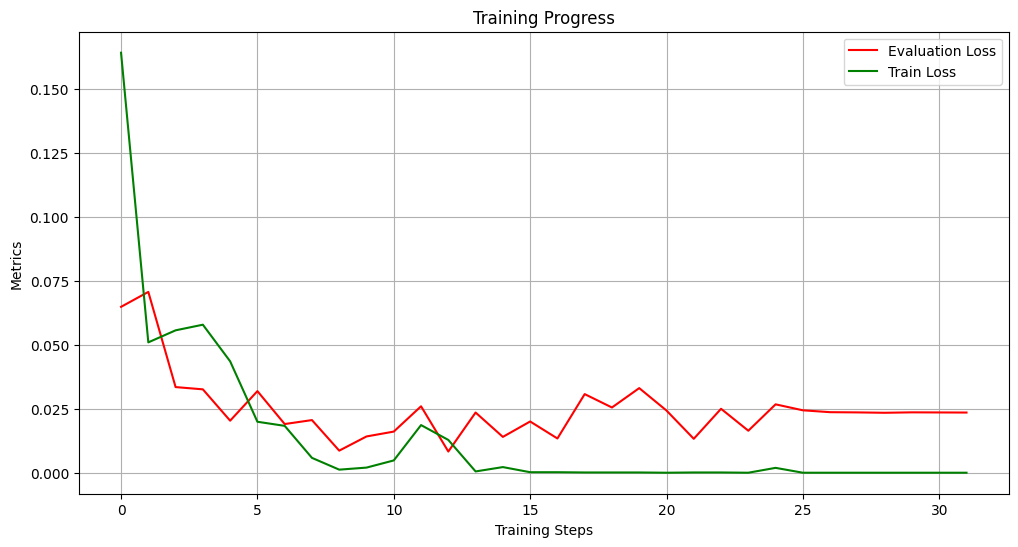

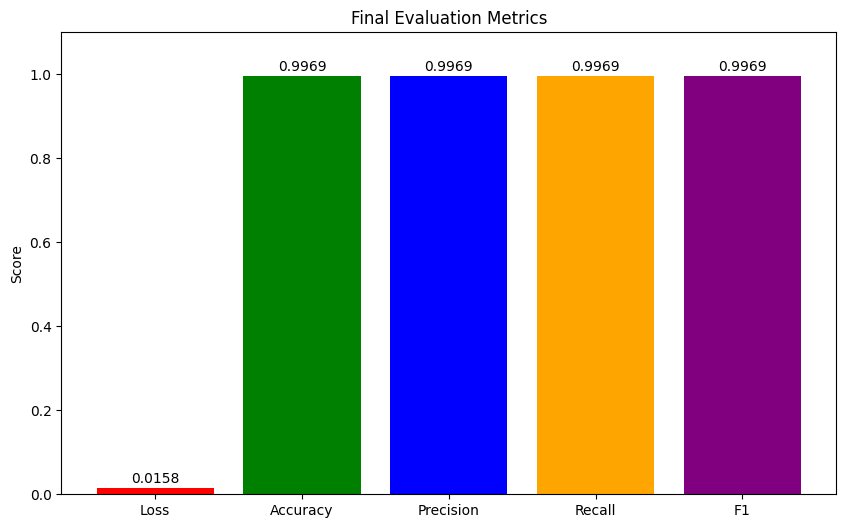

In [56]:
# Mengambil history dari trainer
history = trainer.state.log_history

# Mengekstrak data training dan evaluation
train_loss = [x['loss'] for x in history if 'loss' in x and 'eval_loss' not in x]
eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x][:-1]
eval_accuracy = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]

# Membuat plot
plt.figure(figsize=(12, 6))

# Plot evaluation loss dan accuracy
eval_steps = list(range(len(train_loss)))#[::len(train_loss)//len(eval_loss)])
plt.plot(eval_steps, eval_loss, label='Evaluation Loss', color='red')
plt.plot(eval_steps, train_loss, label='Train Loss', color='green')

plt.title('Training Progress')
plt.xlabel('Training Steps')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)

plt.show()

# Membuat bar plot untuk metrik evaluasi terakhir
final_eval = history[-1]
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1']
values = [final_eval[f'eval_{m.lower()}'] for m in metrics]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['red', 'green', 'blue', 'orange', 'purple'])
plt.title('Final Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 1.1)

for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.show()

In [49]:
len(eval_loss)

31

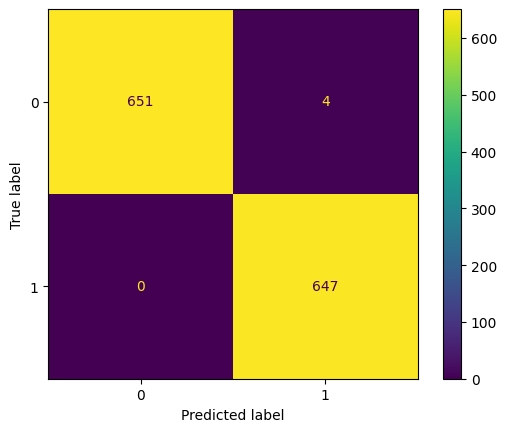

In [64]:
ConfusionMatrixDisplay.from_predictions(pred_label, gt_label);

In [65]:
# take it from tokenized data instead of input
test_data = tokenizer.batch_decode(dataset_full["test"]['input_ids'], skip_special_tokens=True)

# create gt and prediction comparation
pred_compare = []
for i, news in enumerate(test_data):
    pred_compare.append([news, gt_label[i], pred_label[i]])

# turn it to dataframe for easy processing
df_pred_compare = pd.DataFrame(pred_compare)
df_pred_compare = df_pred_compare.rename(columns={0:'news', 1:'labels', 2:'prediction'})
df_pred_compare.to_csv('predictions.csv')
df_pred_compare

,news,labels,prediction
0,"nasdem : pertemuan paloh - prabowo hal baik, p...",0,0
1,buntut panjang kasus dugaan kekerasan benny k ...,0,0
2,"ahy sebut nomor 14 spesial, demokrat usung jar...",0,0
3,"mahfud md akui data negara bocor, tapi bukan d...",0,0
4,"sby bertemu salim segaf di cikeas, bahas isu p...",0,0
...,...,...,...
1297,# ayak2wae penjelasan : akun facebook anto sie...,1,1
1298,assalamualaikum. wr wb. sebelumnya saya perken...,1,1
1299,let s love one another and be there for each o...,1,1
1300,yang minat memiliki / membeli barang lelangan ...,1,1


In [66]:
df_wrong_pred = df_pred_compare[df_pred_compare['labels'] != df_pred_compare['prediction']]
df_pred_compare.to_csv('predictions-wrong.csv')

def label_to_str(label_int):
    label = 'Hoax' if label_int == 1 else 'Fakta'
    return f'{label} [{label_int}]'

for i, row in enumerate(df_wrong_pred.values):
    print(f'{i+1} | {row[0]}')

    print(f'>> Ground Truth label: {label_to_str(row[1])}, but predicted as: {label_to_str(row[2])}')
    print()

1 | pasangan terbaik ri1 ri2 pilpres 2024ganjar pranowo presiden joko widodo inilah pasangan ri1 ri2 2024 harapan rakyat indonesia yang akan menjadi double kekuatan mewujudkan cita cita presiden soekarno membawa nkri menuju indonesia emas yang berdikari mandiri di segala bidang
>> Ground Truth label: Hoax [1], but predicted as: Fakta [0]

2 | rachmawati bungkam mu. lut mak banteng soal ruu bpip. bilang sama megawati jangan bicara pancasila dia hanya anak pungut sukarno
>> Ground Truth label: Hoax [1], but predicted as: Fakta [0]

3 | ini situasi terkini di as negara super power yang menderita, akibat adanya resesi yang melanda dunia. tidak ada yang menggoreng situasi buruk ini untuk kepentingan politik, karena sebagian bangsa yang beradab mereka menganut fatsun politik yang berkeadaban. beda dengan kadrun.
>> Ground Truth label: Hoax [1], but predicted as: Fakta [0]

4 | catalunya barcelona telah menunjuk menteri koordinator bidang kemaritiman dan investasi, luhut binsar pandjaitan seb

In [ ]:
lengths = [len(ids) for ids in ds_train_tokenized['input_ids']]

In [ ]:
lengths

In [ ]:
max_length = max(lengths)

In [ ]:
max_length